<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

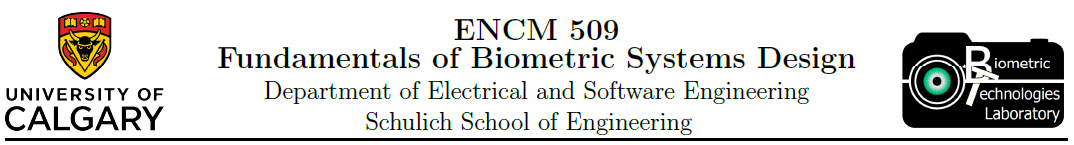

# ENCM 509 - Speaker Recognition Final Project

**Student Names**


**Mushtaba Al Yasseen (30094000)**
\
**Abhay Khosla (30085789)**
\
**Parbir Lehal (30096001)**

In [61]:
# Packages required to run the application 
import numpy as np
from python_speech_features import mfcc
from sklearn.mixture import GaussianMixture
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, det_curve, DetCurveDisplay

### Loading Donald Trump Data

In [4]:
NUMOFTRAININGSAMPLES = 8  # Number of samples to test is a constant

# Directory containing the testing/training data files for Donald Trump
TRUMPREALDATA = "./TrumpReal/"
donaldTrumpTrainingPaths = [f"{TRUMPREALDATA}{i}.wav" for i in range(1, NUMOFTRAININGSAMPLES + 1)] # Training data
donaldTrumpTestingPaths = [f"{TRUMPREALDATA}{i}.wav" for i in range(NUMOFTRAININGSAMPLES + 1, 11)] # Testing data 
donaldTrumpAIPaths = [f"./TrumpAI/{i}.wav" for i in range(1, 11)] # Probe dataset 

### Loading Justin Trudeau Data

In [5]:
# Directory containing the testing/training data files for Justin Trudeau
TRUDEAUREALDATA = "./TrudeauReal/"
justinTrudeauTrainingPaths = [f"{TRUDEAUREALDATA}{i}.wav" for i in range(1, NUMOFTRAININGSAMPLES + 1)] # Training data 
justinTrudeauTestingPaths = [f"{TRUDEAUREALDATA}{i}.wav" for i in range(NUMOFTRAININGSAMPLES + 1, 11)] # Testing data
justinTrudeauAIPaths = [f"./TrumpAI/{i}.wav" for i in range(1, 11)] # Probe dataset 

### Helper Function 1 - Extracting Features from Audio Files (MFCC)

In [6]:
def extractMFCCFeatures(filePaths):
    """Extracts MFCC features from each .wav file specified in the file paths. 

    Parameters
    ----------
    filePaths : list of str
        Paths to the .wav files. 

    Returns
    -------
    numpy.ndarray
        A numpy array of MFCC features from all files.
    """
    features = []
    for filePath in filePaths: 
        # -------------- Start of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
        sample_rate, audio_data = wavfile.read(filePath) # Read the .wav file 
        # -------------- End  of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
        mfcc_data = mfcc(audio_data, samplerate=sample_rate) # Compute the MFCC feautres 
        features.append(mfcc_data)
    return np.concatenate(features, axis=0) # Concatenate the features from all files into a single numpy array

### Helper Function 2 - Calculating GMM Score for Each Audio File

In [7]:
def calculateGMMScores(filePaths, gmmModel):
    """Calculates GMM scores for a given set of file paths using the specified GMM model.

    Parameters
    ----------
    filePaths : list of str
         Paths to the .wav files.
    gmmModel : GaussianMixture
        Trained GMM model.

    Returns
    -------
    list
        A list of GMM scores.
    """
    scores = []
    for filePath in filePaths:
        # -------------- Start of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
        sample_rate, audio_data = wavfile.read(filePath) # Read the .wav file 
        # -------------- End of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
        mfcc_data = mfcc(audio_data, sample_rate) # Compute the MFCC feautres 
        # -------------- Start of Referenced Code from ENCM 509 Lab3-SigVerif GMM.ipynb on D2L---------------
        score = gmmModel.score(mfcc_data) # compute the per-sample average log-likelihood of the given data.
        scores.append(score) # Concatenate the scores from all files into a single list
         # -------------- End of Referenced Code from ENCM 509 Lab3-SigVerif GMM.ipynb on D2L---------------
    return scores

### Helper Function 3 - Plotting Probability Density Function of GMM Real Speech Data vs. AI Generated Speech 

In [34]:
def plotProbabiltyDensityFunction(testScore, aiScore, thresholdValue, subjectName):
    """Plots the probability distributions of real and AI-generated speech scores.

    Parameters
    ----------
    testScore : list 
        GMM scores for the real speech samples.
    aiScore : list
         GMM scores for the AI-generated speech samples.
    thresholdValue : int
       The threshold value to determine the decision boundary.
    label1 : str
        The first label for the plot.
    label2 : str
        The second label for the plot.
    plotTitle : str
        The title for the plot.
    """
    # Determine the range for x values based on the lowest and highest scores from both test and AI scores
    minScore = min(min(testScore), min(aiScore)) 
    maxScore = max(max(testScore), max(aiScore))
    x = np.linspace(minScore - 1, maxScore + 1, 1000)

    # Calculate probability distributions
    geniuineDist = norm.pdf(x, loc=np.mean(testScore), scale=np.std(testScore)) # Calculate the probability distribution (PDF) for the test scores using a normal distribution
    aiDist = norm.pdf(x, loc=np.mean(aiScore), scale=np.std(aiScore)) # Calculate the PDF for the AI scores using a normal distribution

    plt.figure(figsize=(10, 5))  # Begin plotting the figures with a specified figure size
    plt.plot(x, geniuineDist, 'g') # Plot the PDF for the genuine (test) scores
    plt.plot(testScore, np.zeros(len(testScore)), 'gs', lw=2, label=f'{subjectName} Real') # Overlay the test scores on the plot with green squares
    plt.plot(x, aiDist, 'r') # Plot the PDF for the AI scores
    plt.plot(aiScore, np.zeros(len(aiScore)), 'r^', lw=2, label=f'{subjectName} AI') # Overlay the AI scores on the plot with red triangles 
    plt.axvline(thresholdValue, color='b', linestyle='dashed', linewidth=2, label='Threshold') # Draw a vertical line for the threshold value
    plt.xlabel("GMM Scores") # Set the x-axis label
    plt.ylabel("Probability Density Function") # Set the y-axis label
    plt.legend() # Display the legend to describe the elements of the plot
    plt.title(f'{subjectName} Distributions of AI and Genuine Recordings') # Set the title of the plot
    plt.show() # Show the plot on the screen

### Helper Function 4 - Creating Confusion Matrix for Classification

In [49]:
def createConfusionMatrix(testScore, aiScore, thresholdValue, subjectName):
    """
    Calculates the confusion matrix and related rates and plots the confusion matrix.

    Parameters
    ----------
    testScore : list
        GMM scores for the real speech samples.
    aiScore : list
        GMM scores for the AI-generated speech samples.
    thresholdValue : int
        The threshold value to determine the decision boundary.
    trueLabel : list of str
        The labels for the true classes.
    predictedLabel : list of str
        The labels for the predicted classes.
    confusionMatrixTitle : str
        The title for the confusion matrix plot.
    """
    # Initialize confusion matrix values
    TP, FP, TN, FN = 0, 0, 0, 0
    
    # Calculate True Positives, False Negatives, True Negatives, and False Positives
    for score in testScore:
        if score < thresholdValue: # Check if below threshold value then increase the score for FN
            FN += 1
        else:
            TN += 1
    for score in aiScore:
        if score < thresholdValue: # Check if below threshold value then increase the score for TP
            TP += 1
        else:
            FP += 1
            
    # -------------- Start of Referenced Code from ENCM 509 Lab06-FaceRec2024.ipynb on D2L---------------
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))
    # -------------- End  of Referenced Code from ENCM 509 Lab06-FaceRec2024.ipynb on D2L---------------
    cm = np.array([[TP, FP], [FN, TN]])
    labels = np.array(["AI Generated Speech", "Real Speech"]) # Set the labels for the matrix
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap="plasma") # Create the matrix with passing the values for the TP,FP, FN, TN to the matrix
    plt.title(f'{subjectName} Confusion Matrix') # Set the title of the confusion matrix
    plt.show() # Show the confusion matrix on the screen

### Helper Function 5 - Plotting ROC Curve 

In [56]:
def plotROCCurve(trueLabels, predictionScores, subjectName):
    """
    Plots the ROC curve for the given true labels and prediction scores.

    Parameters
    ----------
    trueLabels : list[int]
        The true binary labels for the data (1 for positive class, 0 for negative class).
    predictionScores : list
        The prediction scores outputted by the model, indicating the likelihood of the positive class.
    subjectName : str
        The name of the subject for which the ROC curve is being plotted.
    """
    
    # -------------- Start of Referenced Code from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html on Scikit Learn ROC Curve---------------
    # Compute ROC curve and ROC area for each class
    far, tar, thresholds = roc_curve(trueLabels, predictionScores)
    rocAuc = auc(far, tar)
    # -------------- End of Referenced Code from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html on Scikit Learn ROC Curve---------------
    plt.figure()
    plt.plot(far, tar, color='darkorange', lw=2, label=f'ROC curve (area = {rocAuc:.2f})') # Plot the ROC curve
    plt.scatter(far, tar, color='blue', s=30, label='ROC Points') # Plot the individual points on the ROC curve
    plt.xlabel('False Acceptance Rate (%)') # Set the labels for the x axis
    plt.ylabel('True Acceptance Rate (%)') # Set the labels for the y axis 
    plt.grid(True) # Add grid lines to plot for better readability 
    plt.title(f'ROC Curve for {subjectName}') # Set the title for the curve 
    plt.legend() # Display the legend to describe the elements of the plot
    plt.show()
    threshold_array = np.column_stack((thresholds, far, tar)) # Define the threshold array with the far and tar 
    
    # Print the threshold array in a formatted way
    print("Thresholds | False Acceptance Rate (FAR) | True Acceptance Rate (TAR)")
    for row in threshold_array:
        print(f"{row[0]:.2f} | {row[1]*100:.2f}% | {row[2]*100:.2f}%")

### Helper Function 6 - Plotting DET Curve

### Donald Trump Training Data GMM Model Creation

In [11]:
# create a GMM with n components
# -------------- Start of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
n = 20
donaldTrumpGMM = GaussianMixture(n_components=n) # Initializing the Gaussian mixture model object
# -------------- End of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
donaldTrumpMFCCFeatures = extractMFCCFeatures(donaldTrumpTrainingPaths) # Function call to extract the MFCC features for the training data 
print(donaldTrumpMFCCFeatures[0]) # To see the MFCC fetures array 
# -------------- Start of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
donaldTrumpGMM.fit(donaldTrumpMFCCFeatures) # Fitting the Gaussian Mixture Model to MFCC features  
# -------------- End of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------

C:\Users\abhay\AppData\Local\Temp\ipykernel_9348\3360355181.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(filePath) # Read the .wav file


[-3.60436534e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.65853322e-14  0.00000000e+00  6.86433890e-14  0.00000000e+00
  7.68197924e-14  0.00000000e+00  6.74820084e-14  0.00000000e+00
  3.50716881e-14]


GaussianMixture(n_components=20)

### Donald Trump AI GMM Scoring

In [12]:
donaldTrumpAIScores = calculateGMMScores(donaldTrumpAIPaths, donaldTrumpGMM) # Calculating the GMM scores for the AI probe dataset and passing the trained model 
print(donaldTrumpAIScores) # Printing the AI generated speech scores 

[-47.11504277083021, -47.25742328322277, -46.801030302630465, -46.932912891914015, -47.12559085191799, -47.04854904271367, -47.18123051594093, -47.18542619341036, -47.18025438406287, -47.07963395372256]


### Donald Trump Real Speech GMM Scoring

In [13]:
donaldTrumpTestScores = calculateGMMScores(donaldTrumpTestingPaths, donaldTrumpGMM) # Calculating the GMM scores for the testing dataset and passing the trained model 
print(donaldTrumpTestScores) # Printing the testing real speech scores

C:\Users\abhay\AppData\Local\Temp\ipykernel_9348\4262335479.py:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(filePath) # Read the .wav file


C:\Users\abhay\AppData\Local\Temp\ipykernel_9348\4262335479.py:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(filePath) # Read the .wav file


[-44.789885313807474, -45.00620354848477]


### Donald Trump Probability Density Function

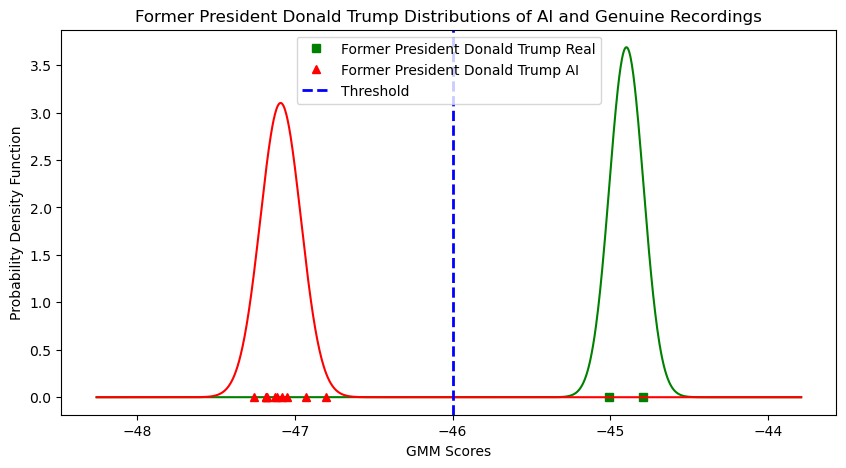

In [35]:
# Calling the helper function to plot the probability density funciton based on the test scores and the AI scores 
DONALDTRUMPTHRESHOLDVALUE = -46
plotProbabiltyDensityFunction(donaldTrumpTestScores, donaldTrumpAIScores, DONALDTRUMPTHRESHOLDVALUE,'Former President Donald Trump')

### Donald Trump Confusion Matrix

	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


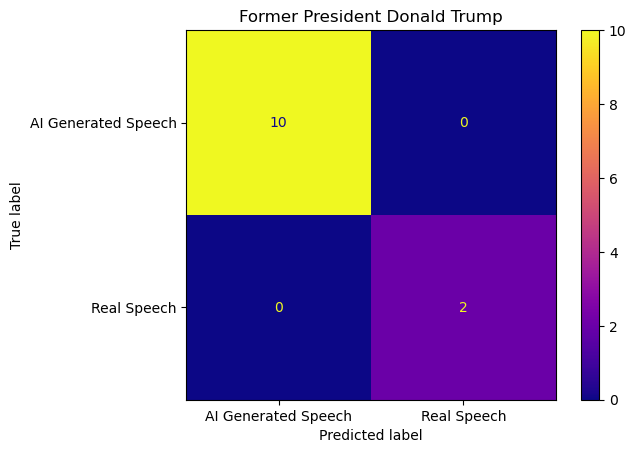

In [26]:
createConfusionMatrix(donaldTrumpTestScores, donaldTrumpAIScores, DONALDTRUMPTHRESHOLDVALUE,'Former President Donald Trump') # Using the helper function to generate the confusion matrix for Donald Trump

### Donald Trump ROC Curve

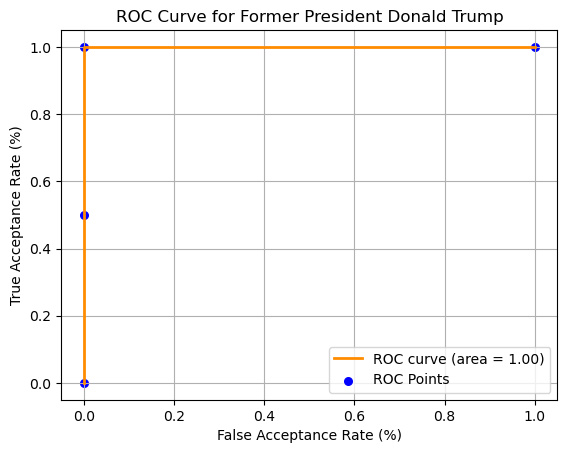

Thresholds | False Acceptance Rate (FAR) | True Acceptance Rate (TAR)
inf | 0.00% | 0.00%
-44.79 | 0.00% | 50.00%
-45.01 | 0.00% | 100.00%
-47.26 | 100.00% | 100.00%


In [58]:
donaldTrumpTrueLabels = [1] * len(donaldTrumpTestScores) + [0] * len(donaldTrumpAIScores) # Create a list of true labels for Donald Trump's speech samples where '1' represents the genuine class (real speech)
donaldTrumpCombinedScores = donaldTrumpTestScores + donaldTrumpAIScores # Combine the list of scores from the real speech samples with the scores from the AI-generated speech samples
plotROCCurve(donaldTrumpTrueLabels, donaldTrumpCombinedScores, 'Former President Donald Trump') # Plot the ROC curve using the combined scores and the corresponding true labels for the subject "Donald Trump"

### Donald Trump DET Curve

### Justin Trudeau Training Data GMM Model Creation

In [17]:
# create a GMM with n components 
n = 20
# -------------- Start of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
justinTrudeauGMM = GaussianMixture(n_components=n) # Initializing the Gaussian mixture model object
# -------------- End of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
justinTrudeauMFCCFeatures = extractMFCCFeatures(justinTrudeauTrainingPaths) # Function call to extract the MFCC features for the training data
print(justinTrudeauMFCCFeatures[0]) # To see the MFCC fetures array
# -------------- Start of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------
justinTrudeauGMM.fit(justinTrudeauMFCCFeatures) # Fitting the Gaussian Mixture Model to MFCC features  
# -------------- End of Referenced Code from ENCM 509 Project-07-SpeakerRecongition v02 on D2L---------------


C:\Users\abhay\AppData\Local\Temp\ipykernel_9348\3360355181.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(filePath) # Read the .wav file


[-3.60436534e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.65853322e-14  0.00000000e+00  6.86433890e-14  0.00000000e+00
  7.68197924e-14  0.00000000e+00  6.74820084e-14  0.00000000e+00
  3.50716881e-14]


GaussianMixture(n_components=20)

### Justin Trudeau AI GMM Scoring

In [18]:
justinTrudeauAIScores = calculateGMMScores(justinTrudeauAIPaths, justinTrudeauGMM) # Calculating the GMM scores for the AI probe dataset and passing the trained model
print(justinTrudeauAIScores) # Printing the AI generated speech scores

[-50.68932207993378, -50.76583410900974, -49.56482580537208, -50.672555818664684, -50.61507619939458, -50.580168751306786, -50.52869344830064, -50.481900511303664, -50.9229899738551, -50.692336970120586]


### Justin Trudeau Real Speech GMM Scoring

In [19]:
justinTrudeauTestScores = calculateGMMScores(justinTrudeauTestingPaths, justinTrudeauGMM) # Calculating the GMM scores for the testing dataset and passing the trained model
print(justinTrudeauTestScores) # Printing the testing real speech scores

C:\Users\abhay\AppData\Local\Temp\ipykernel_9348\4262335479.py:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(filePath) # Read the .wav file


C:\Users\abhay\AppData\Local\Temp\ipykernel_9348\4262335479.py:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(filePath) # Read the .wav file


[-44.49966531001654, -45.634992166165425]


### Justin Trudeau Probability Density Function

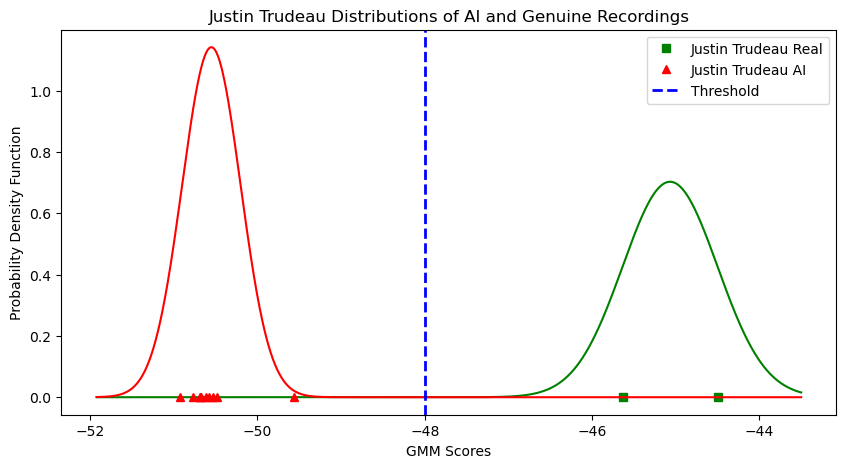

In [25]:
# Calling the helper function to plot the probability density funciton based on the test scores and the AI scores
JUSTINTRUDEAUTHRESHOLDVALUE = -48
plotProbabiltyDensityFunction(justinTrudeauTestScores, justinTrudeauAIScores, JUSTINTRUDEAUTHRESHOLDVALUE, 'Justin Trudeau')

### Justin Trudeau Confusion Matrix

	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


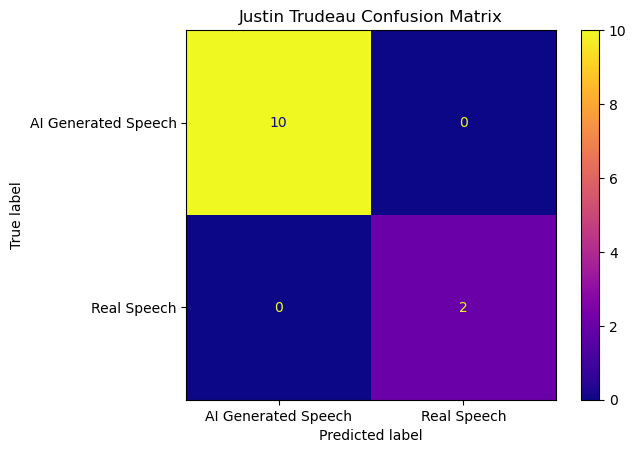

In [27]:
createConfusionMatrix(justinTrudeauTestScores, justinTrudeauAIScores, JUSTINTRUDEAUTHRESHOLDVALUE,'Justin Trudeau Confusion Matrix') # Using the helper function to generate the confusion matrix for Justin Trudeau

### Justin Trudeau ROC Curve

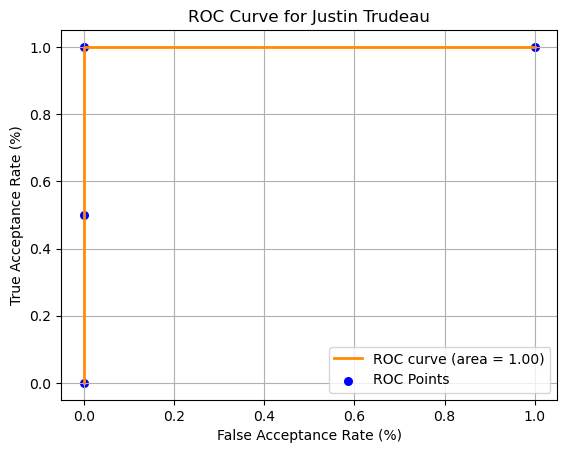

Thresholds | False Acceptance Rate (FAR) | True Acceptance Rate (TAR)
inf | 0.00% | 0.00%
-44.50 | 0.00% | 50.00%
-45.63 | 0.00% | 100.00%
-50.92 | 100.00% | 100.00%


In [59]:
justinTrudeauTrueLabels = [1] * len(justinTrudeauTestScores) + [0] * len(justinTrudeauAIScores) # Create a list of true labels for Justin Trudeau's speech samples where '1' represents the genuine class (real speech)
justinTrudeauCombinedScores = justinTrudeauTestScores + justinTrudeauAIScores # Combine the list of scores from the real speech samples with the scores from the AI-generated speech samples
plotROCCurve(justinTrudeauTrueLabels, justinTrudeauCombinedScores, 'Justin Trudeau') # Plot the ROC curve using the combined scores and the corresponding true labels for the subject "Justin Trudeau"

### Justin Trudeau DET Curve